In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error,mean_squared_error
import os
from sklearn.metrics import precision_score, recall_score, f1_score

Forecasting-based anomaly detection is a common approach for network traffic monitoring.
Our goal is to forecast future traffic and identify anomalies where actual traffic significantly deviates from the forecast. We follow the dataset authors' baseline method, using a SARIMA model with weekly seasonality, and compare a one-shot 7-day forecast to a one-shot 2-day forecast. We also implement a rolling forecast with periodic retraining to simulate continuous monitoring. Finally, we evaluate the forecasts with common error metrics and perform anomaly detection based on prediction intervals.

#### ============= 1. Data Loading=============

In [2]:
# This block loads the traffic flow data for a specific IP address 
# (ID 103) and its corresponding timestamp mapping. 

# Steps:
# - Load IP-level flow count data from hourly-aggregated CSV
# - Load mapping of id_time to actual UTC timestamps
# - Convert timestamp column to pandas datetime format
# - Retain only the necessary columns: id_time and n_flows
# -----------------------------------------------------------
#Data path
data_path = r"C:\Users\sabid\OneDrive\Documents\Tanjila\cesnet-timeseries24\ip_addresses_sample\agg_1_hour\103.csv"
times_path = r"C:\Users\sabid\OneDrive\Documents\Tanjila\cesnet-timeseries24\times\times_1_hour.csv"

# Load CSVs
ip_df = pd.read_csv(data_path)
times_df = pd.read_csv(times_path)

# convert to datetime
times_df['time'] = pd.to_datetime(times_df['time'])

# Select the relevant columns: id_time and n_flows (number of flows in each hour)
ip_df = ip_df[['id_time', 'n_flows']]

#### ============== 2. Data Preprocessing ===================

count      6718.000000
mean      21358.236231
std       24879.214597
min           0.000000
25%        5198.750000
50%       11943.000000
75%       25610.750000
max      137970.000000
Name: n_flows, dtype: float64


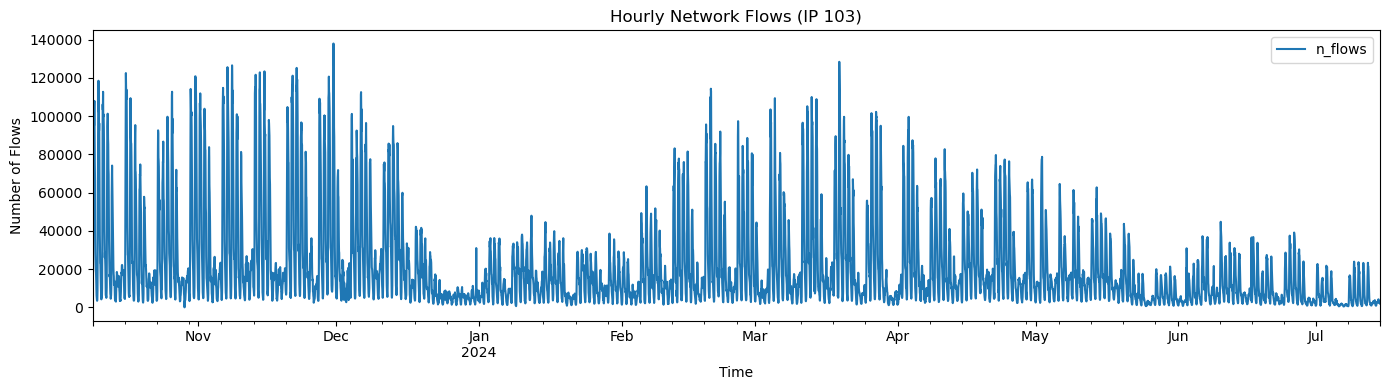

In [3]:
# Merge timestamps: Combine the data with actual timestamps if the data file uses time IDs
# Set datetime index: Convert the timestamp column to DateTimeIndex with hourly frequency.
# Handle gaps: Fill any missing hours in the sequence (e.g. if an hour had no traffic, fill with 0) to maintain a continuous time series. 
# Summary and plotting: Summay statistics for n_flows and a plot is also shown.
# -----------------------------------------------------------


# Align IP data with the full timeline of 1-hour intervals
# Using the times index (all id_time from start to end) and filling missing with 0
df = pd.merge(times_df, ip_df, on="id_time", how="left").sort_values("id_time")
df["n_flows"] = df["n_flows"].fillna(0)

# Set timestamp as index with hourly frequency
df.set_index("time", inplace=True)
df = df.asfreq("h")

# Summary statistics for the number of flows per hour
print(df["n_flows"].describe())

# Plot complete time series
df["n_flows"].plot(title="Hourly Network Flows (IP 103)", figsize=(14, 4))
plt.ylabel("Number of Flows")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.savefig("n_flow_plot.png", dpi=300, bbox_inches='tight')
plt.show()

#### ======== 3. One-shot SARIMA forecast (1,0,0)(0,1,0,168) (7 days vs 2 Days) ==================

AIC: 11955.498264768052
BIC: 11964.210480089443


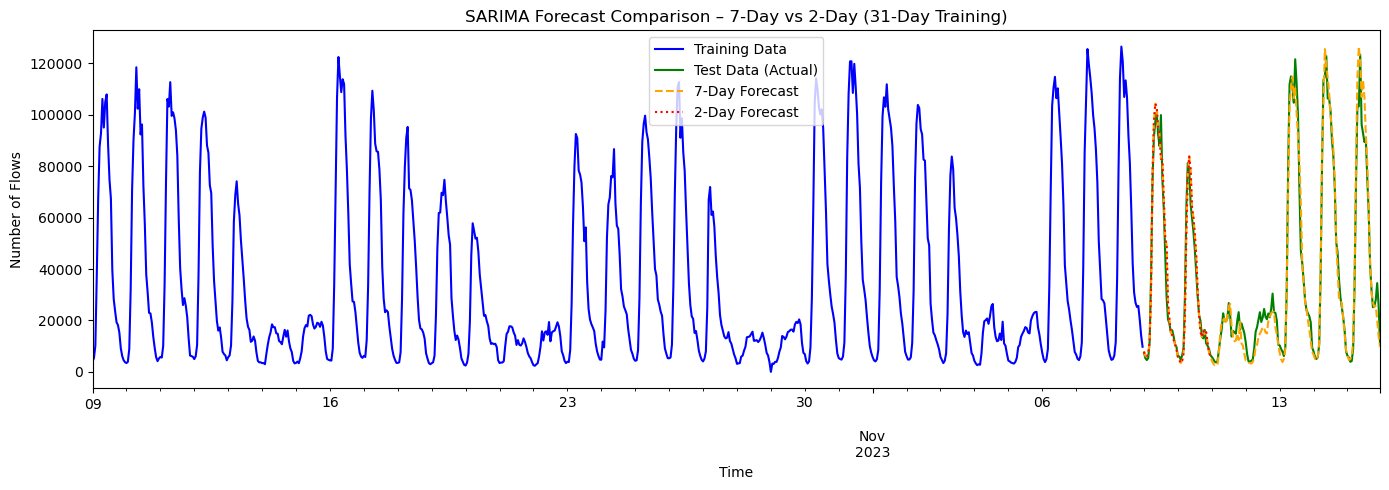

Forecast Evaluation (One-shot SARIMA – 7 Days):
RMSE:  5986.68 flows/hour
MAE:   4134.22 flows/hour
SMAPE: 17.39%
R²:    0.971
Forecast Evaluation (One-shot SARIMA – 2 Days):
RMSE:  5694.00 flows/hour
MAE:   3889.39 flows/hour
SMAPE: 13.46%
R²:    0.968


In [12]:
# One-shot SARIMA Forecasting: 7-Day vs 2-Day Horizon.
# Trains SARIMA(1,0,0)(0,1,0,168) on a 31-day window, then forecasts 7 and 2 days ahead.
# Compares forecast accuracy visually and via metrics (RMSE, MAE, SMAPE, R²).
# -----------------------------------------------------------

# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 168)
train_window = 24 * 31  # 744 hours ≈ 1 month
forecast_horizon_7d = 24 * 7  # 168 hours = 7 days
forecast_horizon_2d = 24 * 2  # 48 hours = 2 days

# Ensure DataFrame is sorted by time
df = df.sort_index()


# 7-DAY FORECAST
train_series_7d = df['n_flows'].iloc[:train_window]
test_series_7d = df['n_flows'].iloc[train_window:train_window + forecast_horizon_7d]

sarima_model_7d = SARIMAX(train_series_7d, order=order, seasonal_order=seasonal_order)
sarima_result_7d = sarima_model_7d.fit(disp=False)
print("AIC:", sarima_result_7d.aic)
print("BIC:", sarima_result_7d.bic)

forecast_7d = sarima_result_7d.forecast(steps=forecast_horizon_7d)
forecast_7d.index = test_series_7d.index  

# 2-DAY FORECAST 
train_series_2d = df['n_flows'].iloc[:train_window]
test_series_2d = df['n_flows'].iloc[train_window:train_window + forecast_horizon_2d]

sarima_model_2d = SARIMAX(train_series_2d, order=order, seasonal_order=seasonal_order)
sarima_result_2d = sarima_model_2d.fit(disp=False)

forecast_2d = sarima_result_2d.forecast(steps=forecast_horizon_2d)
forecast_2d.index = test_series_2d.index

# PLOT COMPARISON
plt.figure(figsize=(14, 5))
train_series_7d.plot(label="Training Data", color='blue')
test_series_7d.plot(label="Test Data (Actual)", color='green')
forecast_7d.plot(label="7-Day Forecast", color='orange', linestyle='--')
forecast_2d.plot(label="2-Day Forecast", color='red', linestyle=':')

plt.title("SARIMA Forecast Comparison – 7-Day vs 2-Day (31-Day Training)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA Forecast 7Days vs 2 Days.png", dpi=300, bbox_inches='tight')
plt.show()

# Evaluation 
def print_metrics(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape = 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    r2 = r2_score(y_true, y_pred)
    print(f"Forecast Evaluation ({label}):")
    print(f"RMSE:  {rmse:.2f} flows/hour")
    print(f"MAE:   {mae:.2f} flows/hour")
    print(f"SMAPE: {smape:.2f}%")
    print(f"R²:    {r2:.3f}")

print_metrics(test_series_7d, forecast_7d, "One-shot SARIMA – 7 Days")
print_metrics(test_series_2d, forecast_2d, "One-shot SARIMA – 2 Days")

#### ==== 4. One-shot SARIMA forecast Anomaly Detection (1,0,0)(0,1,0,168)  (7 Days and 2 Days) ===========

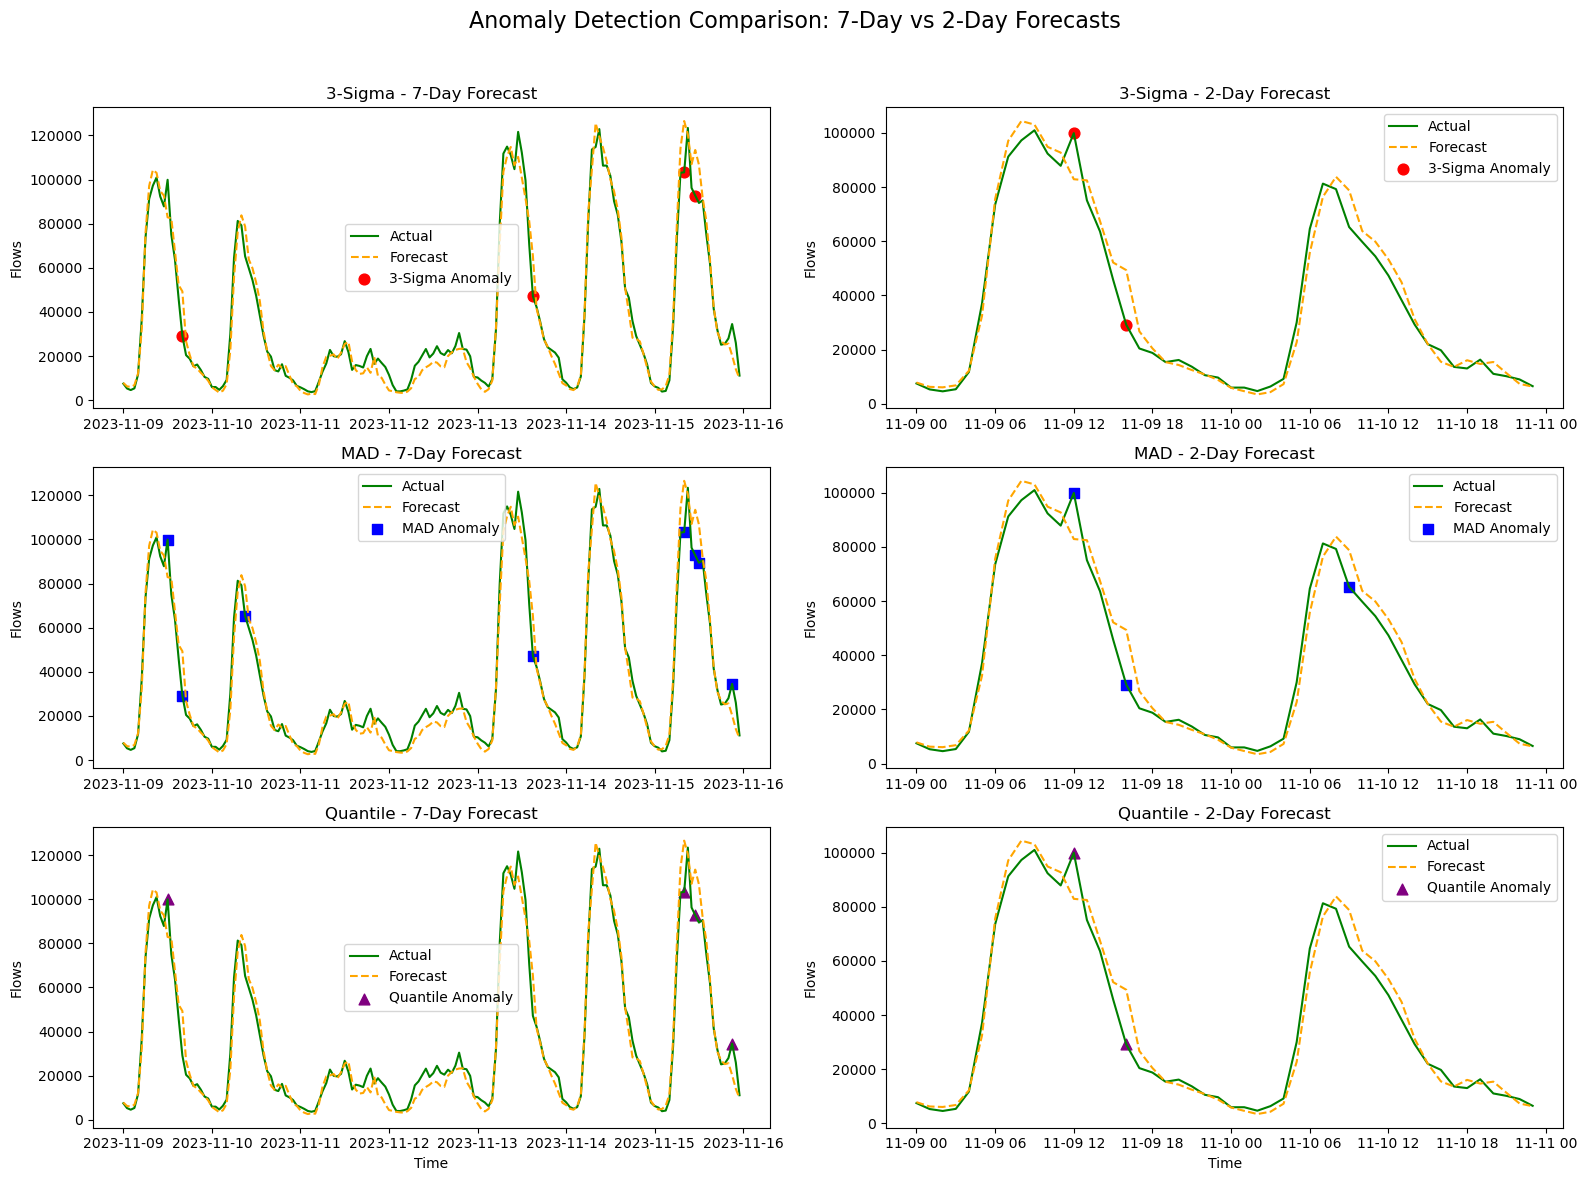

Anomaly Detection Summary Table:
  Method  7-Day Anomalies  2-Day Anomalies
 3-Sigma                4                2
     MAD                8                3
Quantile                4                2


In [11]:
# Anomaly Detection: 7-Day vs 2-Day Forecast Comparison

# This block performs residual-based anomaly detection on two SARIMA 
# forecast horizons (7-day and 2-day). Three statistical methods are used:
#    1. 3-Sigma 
#    2. Median Absolute Deviation (MAD)
#    3. Quantile-based thresholding (1st and 99th percentiles)
#
# Steps:
# - Compute residuals (actual - forecast) for both 7-day and 2-day forecasts
# - Detect anomalies using the 3 methods
# - Visualize results in a single 3x2 comparison plot (methods × horizons)
# - Summarize anomaly counts for each method and forecast length

# Output:
# - Saved plot: ./anomaly_plots/anomaly_detection_7d_2d_comparison.png
# - Printed summary table of anomaly counts
# -----------------------------------------------------------
# Anomaly Detection Function 
def detect_anomalies(residuals):
    # 3-Sigma
    res_mean = residuals.mean()
    res_std = residuals.std()
    anomalies_3sigma = (residuals > res_mean + 3 * res_std) | (residuals < res_mean - 3 * res_std)

    # MAD
    med = residuals.median()
    mad = np.median(np.abs(residuals - med))
    mad_scaled = 1.4826 * mad
    anomalies_mad = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

    # Quantile
    q_lo = residuals.quantile(0.01)
    q_hi = residuals.quantile(0.99)
    anomalies_quant = (residuals < q_lo) | (residuals > q_hi)

    return anomalies_3sigma.astype(bool), anomalies_mad.astype(bool), anomalies_quant.astype(bool)

# Create output folder
output_dir = "anomaly_plots"
os.makedirs(output_dir, exist_ok=True)

# Detect anomalies from residuals
residuals_7d = test_series_7d - forecast_7d
residuals_2d = test_series_2d - forecast_2d

anomalies_3sigma_7d, anomalies_mad_7d, anomalies_quant_7d = detect_anomalies(residuals_7d)
anomalies_3sigma_2d, anomalies_mad_2d, anomalies_quant_2d = detect_anomalies(residuals_2d)

# Plot all in one 3x2 comparison figure 
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=False)

methods = ["3-Sigma", "MAD", "Quantile"]
colors = ["red", "blue", "purple"]
markers = ["o", "s", "^"]

anomaly_sets = [
    (anomalies_3sigma_7d, anomalies_3sigma_2d),
    (anomalies_mad_7d, anomalies_mad_2d),
    (anomalies_quant_7d, anomalies_quant_2d)
]

for i, (method, color, marker) in enumerate(zip(methods, colors, markers)):
    # 7-Day Forecast
    axes[i, 0].plot(test_series_7d.index, test_series_7d, label='Actual', color='green')
    axes[i, 0].plot(forecast_7d.index, forecast_7d, label='Forecast', color='orange', linestyle='--')
    axes[i, 0].scatter(test_series_7d.index[anomaly_sets[i][0]], test_series_7d[anomaly_sets[i][0]],
                      color=color, s=60, marker=marker, label=f'{method} Anomaly')
    axes[i, 0].set_title(f"{method} - 7-Day Forecast")
    axes[i, 0].set_ylabel("Flows")
    axes[i, 0].legend()

    # 2-Day Forecast
    axes[i, 1].plot(test_series_2d.index, test_series_2d, label='Actual', color='green')
    axes[i, 1].plot(forecast_2d.index, forecast_2d, label='Forecast', color='orange', linestyle='--')
    axes[i, 1].scatter(test_series_2d.index[anomaly_sets[i][1]], test_series_2d[anomaly_sets[i][1]],
                      color=color, s=60, marker=marker, label=f'{method} Anomaly')
    axes[i, 1].set_title(f"{method} - 2-Day Forecast")
    axes[i, 1].set_ylabel("Flows")
    axes[i, 1].legend()

# Label x-axis on bottom row only
for ax in axes[2]:
    ax.set_xlabel("Time")

plt.suptitle("Anomaly Detection Comparison: 7-Day vs 2-Day Forecasts", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(os.path.join(output_dir, "anomaly_detection_7d_2d_comparison.png"), dpi=300, bbox_inches='tight')
plt.show()

# Summary Table
anomaly_summary = pd.DataFrame({
    "Method": methods,
    "7-Day Anomalies": [an.sum() for an in [anomalies_3sigma_7d, anomalies_mad_7d, anomalies_quant_7d]],
    "2-Day Anomalies": [an.sum() for an in [anomalies_3sigma_2d, anomalies_mad_2d, anomalies_quant_2d]]
})

print("Anomaly Detection Summary Table:")
print(anomaly_summary.to_string(index=False))

#### ======== 5. Rolling Forecasting with SARIMA for 2 Days (May 2024 Outage Period)==============

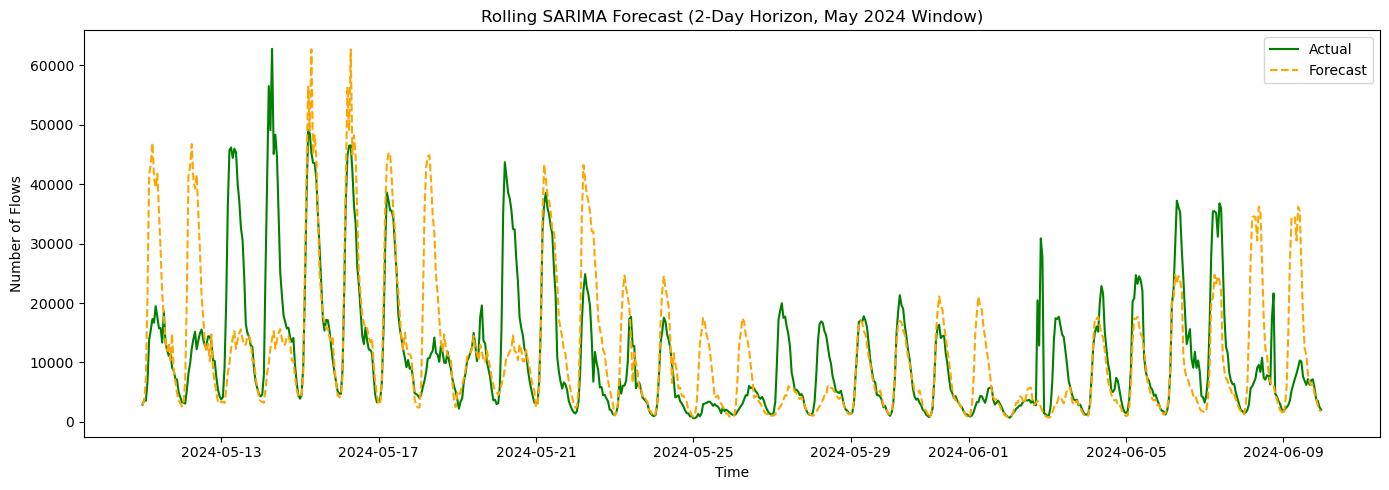

          Precision  Recall  F1-Score      RMSE      MAE    R2  SMAPE
3-Sigma        0.15    0.01      0.02  10193.27  5877.32  0.13  45.36
MAD            0.42    0.20      0.27  10193.27  5877.32  0.13  45.36
Quantile       0.12    0.01      0.01  10193.27  5877.32  0.13  45.36


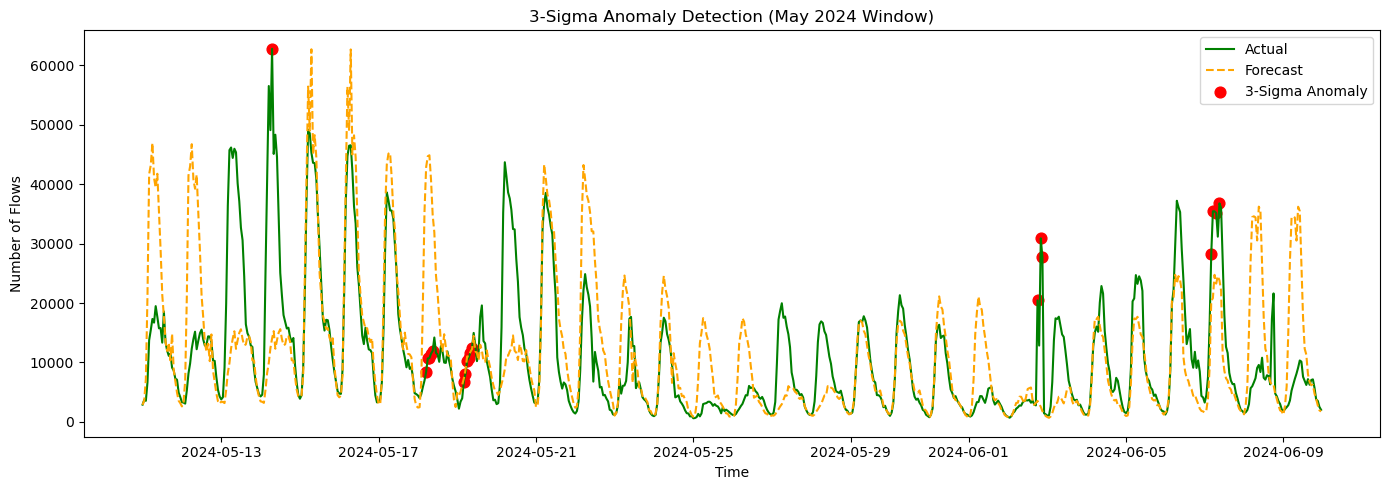

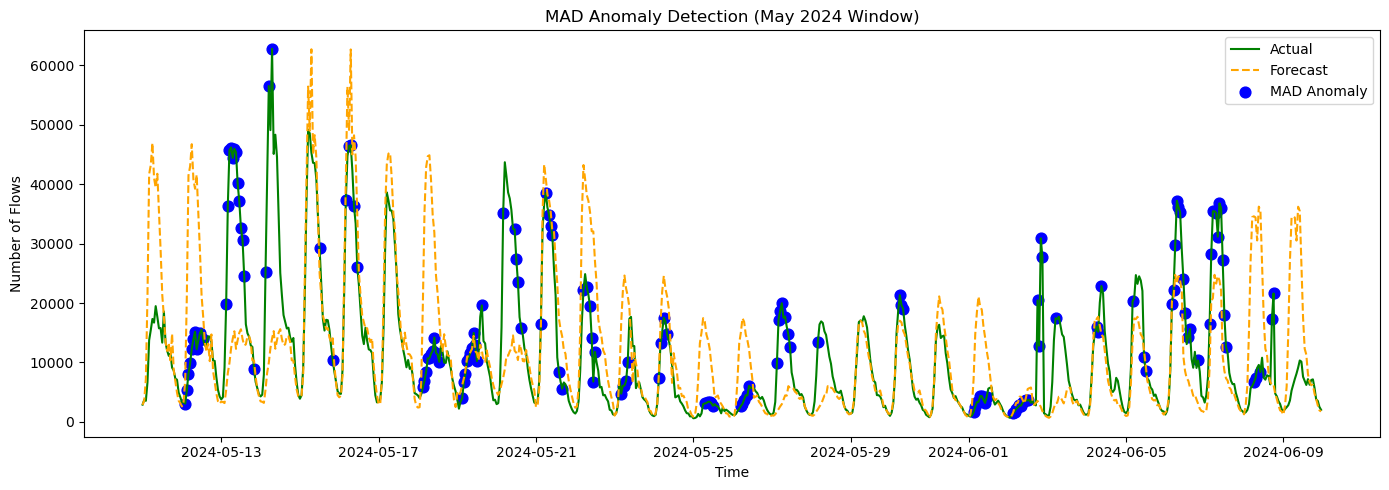

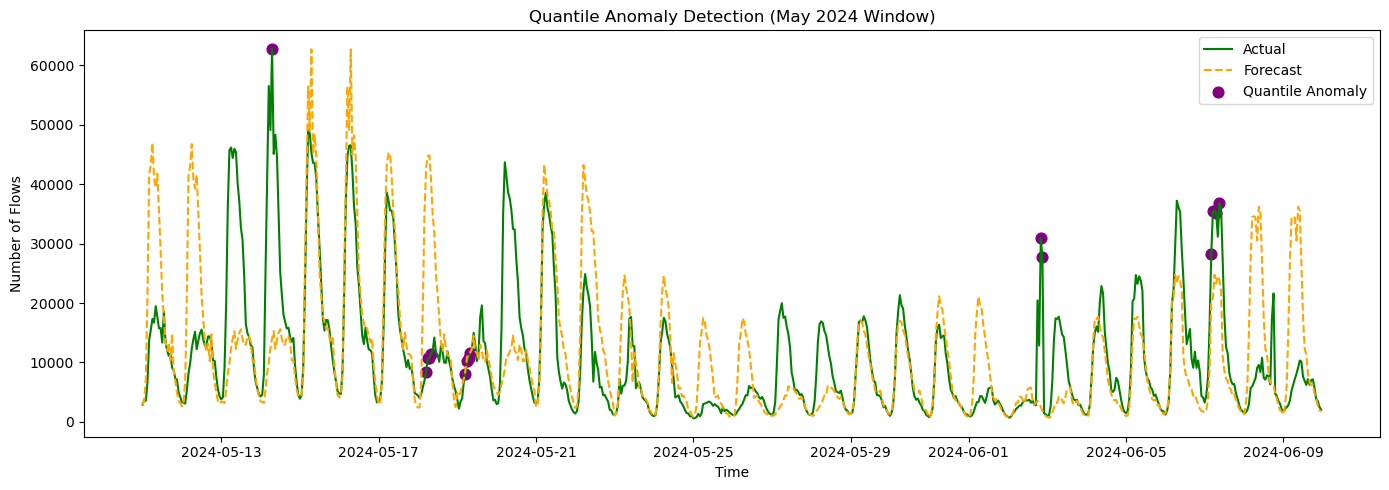

In [13]:
# Rolling SARIMA Forecast & Anomaly Detection (May 2024 Outage Period)

# Objective:
# - Use a rolling 2-day SARIMA forecast to model network traffic
# - Evaluate anomaly detection performance against known outage (May 21–June 4, 2024)

# Steps:
# 1. Load and filter the time series data around the anomaly period.
# 2. Perform rolling SARIMA(1,0,0)(0,1,0,24) forecasts using a 21-day training window.
# 3. Collect actual vs. predicted values across the forecast horizon.
# 4. Compute evaluation metrics: RMSE, MAE, R², SMAPE.
# 5. Apply STL decomposition to isolate residuals for anomaly detection.
# 6. Use 3-Sigma, MAD, and Quantile-based thresholds to flag anomalies.
# 7. Compare predicted anomalies against the ground-truth outage window.
# 8. Compute Precision, Recall, and F1-Score for each detection method.
# -----------------------------------------------------------

# Extracting April 20 to June 10, 2024 dataset
df = df["2024-04-20":"2024-06-10"]

# Parameters
order = (1, 0, 0)
seasonal_order = (0, 1, 0, 24)
train_window = 24 * 21  # 21 days
forecast_horizon = 24 * 2  # 2 days

start = train_window
predictions = []
actuals = []
forecast_index = []

while start + forecast_horizon <= len(df):
    train_series = df['n_flows'].iloc[start - train_window:start]
    test_series = df['n_flows'].iloc[start:start + forecast_horizon]

    model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)
    forecast = result.forecast(steps=forecast_horizon)

    predictions.extend(forecast.values)
    actuals.extend(test_series.values)
    forecast_index.extend(test_series.index)
    start += forecast_horizon

# Forecast vs Actual
forecast_series = pd.Series(predictions, index=forecast_index)
actual_series = pd.Series(actuals, index=forecast_index)

# Metrics
rmse = np.sqrt(mean_squared_error(actual_series, forecast_series))
mae = mean_absolute_error(actual_series, forecast_series)
r2 = r2_score(actual_series, forecast_series)
smape = 100 * np.mean(np.abs(actual_series - forecast_series) / ((np.abs(actual_series) + np.abs(forecast_series)) / 2))

# Plot Forecast
plt.figure(figsize=(14, 5))
plt.plot(actual_series.index, actual_series, label="Actual", color='green')
plt.plot(forecast_series.index, forecast_series, label="Forecast", color='orange', linestyle='--')
plt.title("Rolling SARIMA Forecast (2-Day Horizon, May 2024 Window)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("forecast_vs_actual_May2024.png", dpi=300)
plt.show()

# Anomaly Detection using STL Residuals 
resid_stl = STL(actual_series, period=24, robust=True).fit().resid
res_mean = resid_stl.mean()
res_std = resid_stl.std()
mad = np.median(np.abs(resid_stl - np.median(resid_stl)))
mad_scaled = 1.4826 * mad
q_lo, q_hi = resid_stl.quantile([0.01, 0.99])

anomalies_3sigma = ((resid_stl > res_mean + 3 * res_std) | (resid_stl < res_mean - 3 * res_std)).astype(int)
anomalies_mad = ((resid_stl > np.median(resid_stl) + 3 * mad_scaled) | (resid_stl < np.median(resid_stl) - 3 * mad_scaled)).astype(int)
anomalies_quant = ((resid_stl < q_lo) | (resid_stl > q_hi)).astype(int)


# Ground Truth Anomalies (Outage Period) 
ground_truth = pd.Series(0, index=forecast_series.index)
ground_truth[(forecast_series.index >= "2024-05-21") & (forecast_series.index <= "2024-06-04")] = 1

# Evaluation Function
def evaluate(true, pred):
    return {
        "Precision": precision_score(true, pred, zero_division=0),
        "Recall": recall_score(true, pred, zero_division=0),
        "F1-Score": f1_score(true, pred, zero_division=0)
    }

results = {
    "3-Sigma": evaluate(ground_truth, anomalies_3sigma),
    "MAD": evaluate(ground_truth, anomalies_mad),
    "Quantile": evaluate(ground_truth, anomalies_quant)
}

results_df = pd.DataFrame(results).T
results_df["RMSE"] = rmse
results_df["MAE"] = mae
results_df["R2"] = r2
results_df["SMAPE"] = smape


print(results_df.round(2))

# Return forecast metrics as well
forecast_metrics = {
    "RMSE": rmse,
    "MAE": mae,
    "R²": r2,
    "SMAPE": smape
}
# Plotting all three detection methods
def plot_anomaly_result(actual, forecast, anomaly_mask, method_name, color, filename):
    plt.figure(figsize=(14, 5))
    plt.plot(actual.index, actual, label="Actual", color='green')
    plt.plot(forecast.index, forecast, label="Forecast", color='orange', linestyle='--')
    plt.scatter(actual.index[anomaly_mask.astype(bool)],
                actual[anomaly_mask.astype(bool)],
                color=color, label=f"{method_name} Anomaly", s=60, marker='o')
    plt.title(f"{method_name} Anomaly Detection (May 2024 Window)")
    plt.xlabel("Time")
    plt.ylabel("Number of Flows")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# Save individual anomaly detection plots
plot_anomaly_result(actual_series, forecast_series, anomalies_3sigma, "3-Sigma", "red", "anomaly_3sigma.png")
plot_anomaly_result(actual_series, forecast_series, anomalies_mad, "MAD", "blue", "anomaly_mad.png")
plot_anomaly_result(actual_series, forecast_series, anomalies_quant, "Quantile", "purple", "anomaly_quantile.png")

#### ======= MISC: 6. One-shot SARIMA forecast with config (1,1,1)(1,1,0,168) for 7 Days ==============

AIC: 6699.883225905669
BIC: 6715.139748032969


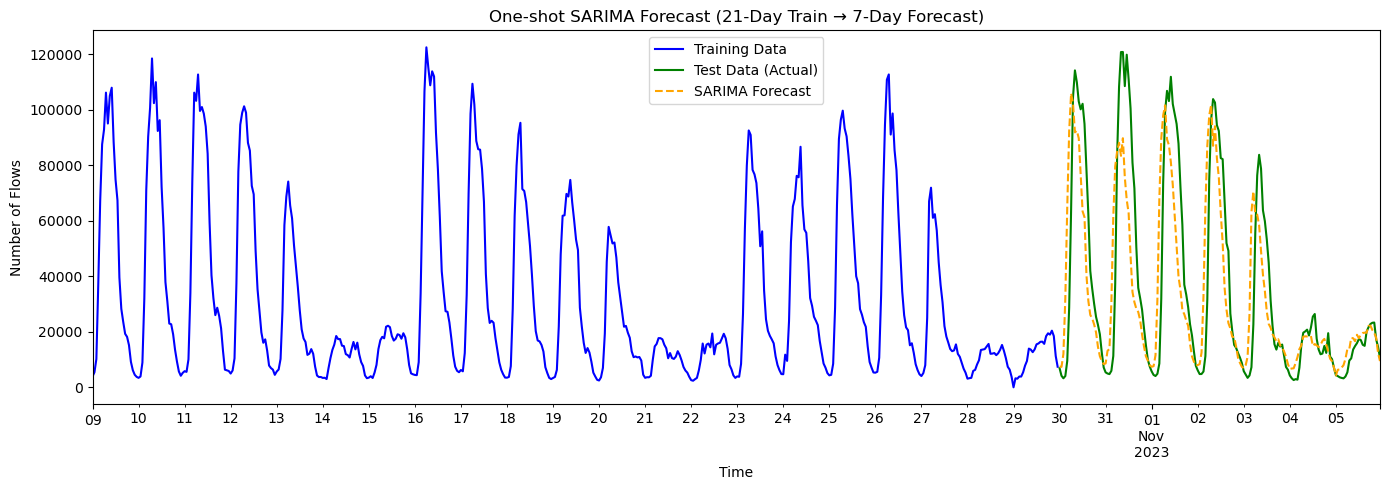

Forecast Evaluation (One-shot SARIMA (1,1,1)(1,1,0,168) 7 Days):
RMSE:  21817.59 flows/hour
MAE:   14495.45 flows/hour
R²:    0.635
SMAPE: 43.78%


In [4]:
# One-shot SARIMA Forecast 21-Day Train, 7-Day Test

# This block trains a SARIMA(1,1,1)(1,1,0,168) model on 21 days of hourly traffic data and 
# forecasts the next 7 days. The weekly seasonal cycle (168 hours) is captured via SARIMA's
# seasonal component. The predicted values are compared against actuals using 
# evaluation metrics: RMSE, MAE, R², and SMAPE. Results are shown and saved as a plot.
# ----------------------------------------------------------------------------------------

# Parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 0, 168)
train_window = 24 * 21  # 504 hours ≈ 3 weeks
forecast_horizon = 24 * 7 # 168 hours = 1 week

# Ensure DataFrame is sorted by time
df = df.sort_index()

# Define train and test slices
train_series = df['n_flows'].iloc[:train_window]
test_series = df['n_flows'].iloc[train_window:train_window + forecast_horizon]

# Fit SARIMA on training data
sarima_model = SARIMAX(train_series, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit(disp=False)
print("AIC:", sarima_result.aic)
print("BIC:", sarima_result.bic)

# Forecast the next 7 days
forecast = sarima_result.forecast(steps=forecast_horizon)
forecast.index = test_series.index  # Align forecast with actual

# Plot forecast vs actual
plt.figure(figsize=(14, 5))
train_series.plot(label="Training Data", color='blue')
test_series.plot(label="Test Data (Actual)", color='green')
forecast.plot(label="SARIMA Forecast", color='orange', linestyle='--')

plt.title("One-shot SARIMA Forecast (21-Day Train → 7-Day Forecast)")
plt.xlabel("Time")
plt.ylabel("Number of Flows")
plt.legend()
plt.tight_layout()
plt.savefig("SARIMA_1shot_7day.png", dpi=300, bbox_inches='tight')
plt.show()

# Evaluate forecast
rmse = np.sqrt(mean_squared_error(test_series, forecast))
mae = mean_absolute_error(test_series, forecast)
r2 = r2_score(test_series, forecast)

# Compute SMAPE 
numerator = np.abs(test_series - forecast)
denominator = (np.abs(test_series) + np.abs(forecast)) / 2
smape = 100 * np.mean(np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0))

print("Forecast Evaluation (One-shot SARIMA (1,1,1)(1,1,0,168) 7 Days):")
print(f"RMSE:  {rmse:.2f} flows/hour")
print(f"MAE:   {mae:.2f} flows/hour")
print(f"R²:    {r2:.3f}")
print(f"SMAPE: {smape:.2f}%")

#### ========= MISC: 6. One-shot SARIMA Anomaly Detection (1,1,1)(1,1,0,168) for 7 days ===============

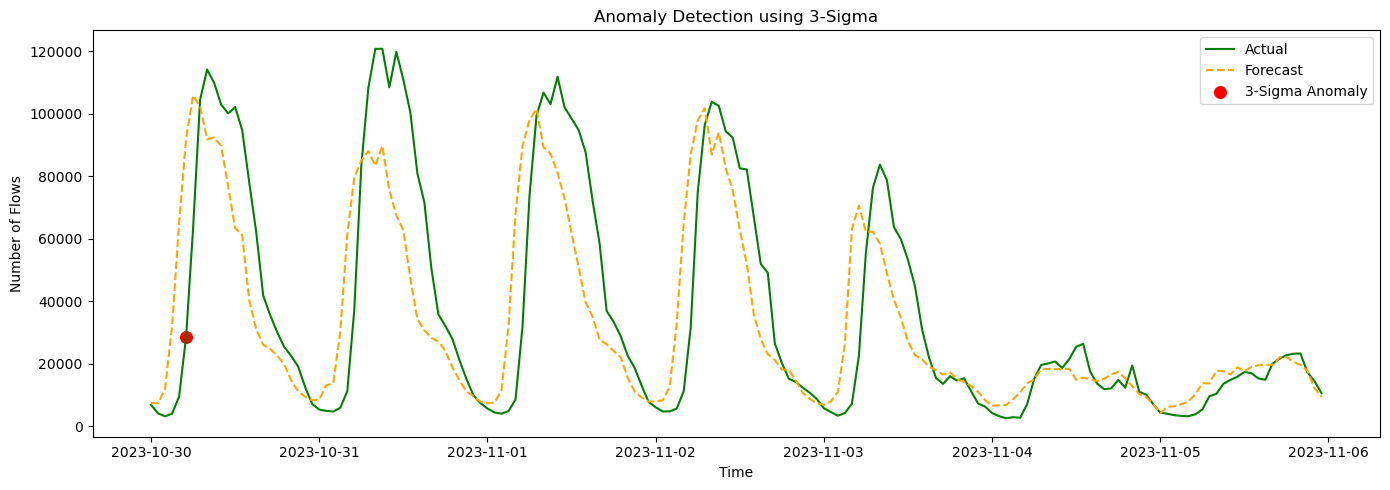

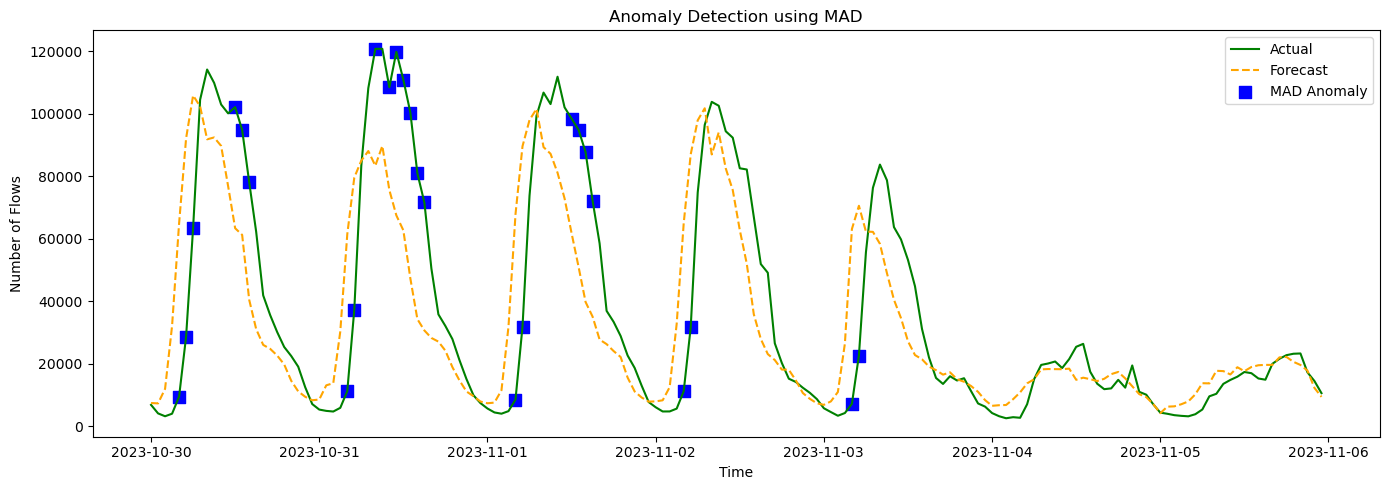

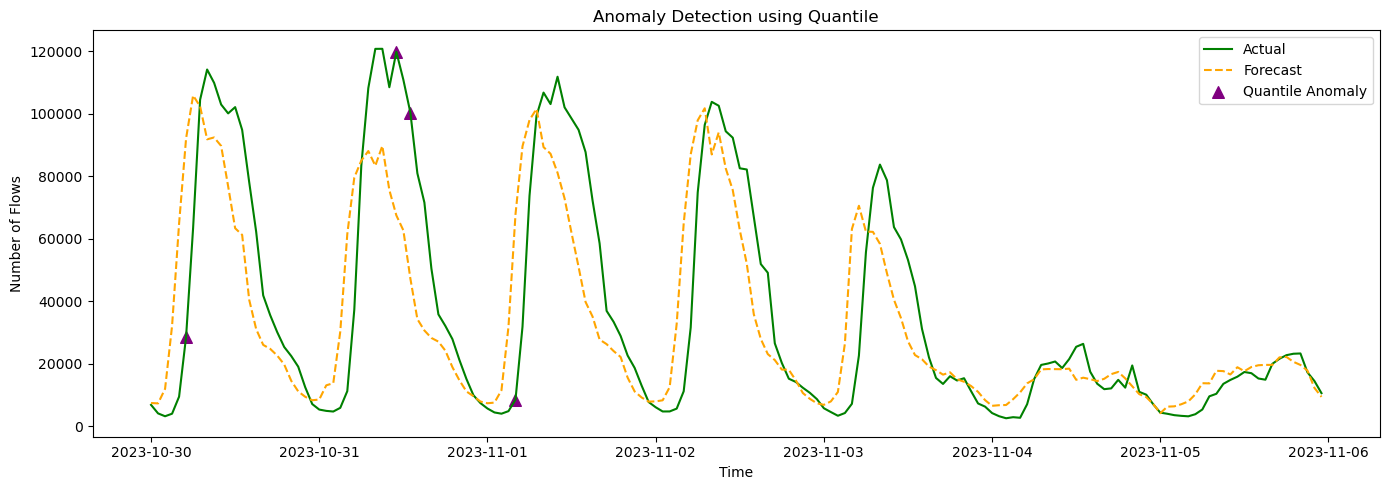

Anomalies Detected in Test Period:
• 3-Sigma method      : 1 points
• MAD method          : 25 points
• Quantile method     : 4 points


In [5]:
# Residual-Based Anomaly Detection (One-shot Forecast)

# This section identifies anomalies by analyzing residuals (actual - forecast) using:
# - 3-Sigma 
# - Median Absolute Deviation (MAD)
# - Quantile-based detection (1st and 99th percentiles)

# Anomalies are plotted and the number of flagged points is printed by method.
# ----------------------------------------------------------------------------------------

# Residuals (168 values) 
residuals = test_series - forecast

# 3-Sigma Detection
res_mean = residuals.mean()
res_std = residuals.std()
anomalies_3sigma = (residuals > res_mean + 3 * res_std) | (residuals < res_mean - 3 * res_std)

# MAD Detection
med = residuals.median()
mad = np.median(np.abs(residuals - med))
mad_scaled = 1.4826 * mad
anomalies_mad = (residuals > med + 3 * mad_scaled) | (residuals < med - 3 * mad_scaled)

# Quantile Detection
q_lo = residuals.quantile(0.01)
q_hi = residuals.quantile(0.99)
anomalies_quant = (residuals < q_lo) | (residuals > q_hi)

# Create folder if it doesn't exist
output_dir = "anomaly_plots"
os.makedirs(output_dir, exist_ok=True)

# Reusable plot function (filename auto-generated from method_name)
def plot_anomaly_method(series, forecast, anomaly_mask, method_name, color, marker):
    series = series.copy()
    forecast = forecast.copy()
    anomaly_mask = anomaly_mask.reindex(series.index, fill_value=False)

    plt.figure(figsize=(14, 5))
    plt.plot(series.index, series, label='Actual', color='green')
    plt.plot(forecast.index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.scatter(series.index[anomaly_mask], series[anomaly_mask],
                color=color, s=70, marker=marker, label=f'{method_name} Anomaly')
    plt.title(f'Anomaly Detection using {method_name}')
    plt.xlabel("Time")
    plt.ylabel("Number of Flows")
    plt.legend()
    plt.tight_layout()

    # Automatically create filename from method name
    filename = os.path.join(output_dir, f"anomaly_{method_name.lower().replace('-', '').replace(' ', '')}.png")
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot and save all
plot_anomaly_method(test_series, forecast, anomalies_3sigma, "3-Sigma", 'red', 'o')
plot_anomaly_method(test_series, forecast, anomalies_mad, "MAD", 'blue', 's')
plot_anomaly_method(test_series, forecast, anomalies_quant, "Quantile", 'purple', '^')

# Summary
print("Anomalies Detected in Test Period:")
print(f"• 3-Sigma method      : {anomalies_3sigma.sum()} points")
print(f"• MAD method          : {anomalies_mad.sum()} points")
print(f"• Quantile method     : {anomalies_quant.sum()} points")